In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings("ignore")
import lmfit
import scipy
from astropy.coordinates import Distance
from astropy.cosmology import Planck15
from scipy.integrate import simps
#from scipy import interpolate
import pandas as pd
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from numpy import loadtxt
from astropy.io import fits
import math
import os
from grizli.catalog import query_tap_catalog
from scipy.signal import find_peaks
import eazy


## Load fits data from Super-deblended" COSMOS 2018 (Jin+, 2018) 
https://ui.adsabs.harvard.edu/abs/2018ApJ...864...56J/abstract

In [3]:
Deblended = fits.open("Dub_with_zspec_and_FIR.fit")

Dub_data = Deblended[1].data

Dub_header = Deblended[1].header



In [3]:
Dub_header

XTENSION= 'BINTABLE'           / Binary Table Extension                         
BITPIX  =                    8 / binary data                                    
NAXIS   =                    2 / Simple 2-D matrix                              
NAXIS1  =                   72 / Number of bytes per record                     
NAXIS2  =                 1219 / Number of records                              
PCOUNT  =                    0 / Get rid of random parameters                   
GCOUNT  =                    1 / Only one group (isn't it obvious?)             
TFIELDS =                   10 / Number of data fields (columns)                
CDS-CAT = 'J/ApJ/864/56'       / Catalogue designation in CDS nomenclature      
         "Super-deblended" dust emission in gal. II. COSMOS (Jin+, 2018)        
EXTNAME = 'J_ApJ_864_56_catalog' / Identification of the table                  
CDS-NAME= 'J/ApJ/864/56/catalog' / Table name in METAtab                        
         COSMOS "Super-deble

## Load The COSMOS2015 catalog (Laigle+, 2016)
https://ui.adsabs.harvard.edu/abs/2017yCat..22240024L/abstract

In [4]:
Cosmos2015 = fits.open("Cosmos2015_Filter2_Optical.fit")

cosmos2015_data = Cosmos2015[1].data

cosmos2015_header = Cosmos2015[1].header



In [5]:
# cosmos2015_header

## Find common galaxy Id's in both catalog for combining

In [6]:


common_galaxies_ID = Dub_data['ID'][np.array([index for index, value in enumerate(Dub_data['ID']) if value in cosmos2015_data['Seq']])]


index_for_FIR = np.where(Dub_data['ID']==common_galaxies_ID)




In [7]:


FIR_indices = np.array([index for index, value in enumerate(Dub_data['ID']) if value in common_galaxies_ID])

OPTICAL_indices = np.array([index for index, value in enumerate(cosmos2015_data['Seq']) if value in common_galaxies_ID])



In [10]:
#Convert color mag to flux density in mJy

def flux_density(ab_mag):
    return 10 ** ((ab_mag - 23.9) / -2.5)

def flux_density_error(ab_mag, delta_ab_mag):

    df_dmag = flux_density(ab_mag)

    delta_flux = abs(df_dmag) * delta_ab_mag* math.log(10) / 2.5

    return delta_flux



## Create my own galaxy catalog using available filters, to run it through EAZY Optical Code:

In [13]:



import numpy as np
import pandas as pd

# Create some sample data

# header_name=['Seq','Fu','e_Fu','FB','e_FB','FV','e_FV','FR','e_FR','Fi','e_Fi','FKs','e_FKs','FJ','e_FJ','FH','e_FH','FY','e_FY','F3_6','e_F3_6','F4_5','e_F4_5','F5_8','e_F5_8','F8_0','e_F8_0']

# header_name=['Seq','FB','e_FB','FV','e_FV','FR','e_FR','Fi','e_Fi','FKs','e_FKs']

header_name=['Seq','Fu','e_Fu','FR','e_FR','Fi','e_Fi','FKs','e_FKs','FJ','e_FJ','FH','e_FH']

uncertainty_scale = 20


# FIR_index
cosmos2015_filtered_index  = OPTICAL_indices


Seq = cosmos2015_data['Seq'][cosmos2015_filtered_index]




e_Fu = uncertainty_scale* flux_density_error(cosmos2015_data['umag'][cosmos2015_filtered_index],cosmos2015_data['e_umag'][cosmos2015_filtered_index])

Fu = flux_density(cosmos2015_data['umag'][cosmos2015_filtered_index])

Fu = np.random.normal(loc=Fu, scale=e_Fu)

# FB = flux_density(cosmos2015_data['Bmag'][cosmos2015_filtered_index])
# e_FB = flux_density_error(cosmos2015_data['Bmag'][cosmos2015_filtered_index],cosmos2015_data['e_Bmag'][cosmos2015_filtered_index])

# FV = flux_density(cosmos2015_data['Vmag'][cosmos2015_filtered_index])
# e_FV = flux_density_error(cosmos2015_data['Vmag'][cosmos2015_filtered_index],cosmos2015_data['e_Vmag'][cosmos2015_filtered_index])

FR = flux_density(cosmos2015_data['rmag'][cosmos2015_filtered_index])
e_FR = uncertainty_scale*flux_density_error(cosmos2015_data['rmag'][cosmos2015_filtered_index],cosmos2015_data['e_rmag'][cosmos2015_filtered_index])

FR = np.random.normal(loc=FR, scale=e_FR)


Fi = flux_density(cosmos2015_data['ipmag'][cosmos2015_filtered_index])
e_Fi = uncertainty_scale*flux_density_error(cosmos2015_data['ipmag'][cosmos2015_filtered_index],cosmos2015_data['e_ipmag'][cosmos2015_filtered_index])

Fi = np.random.normal(loc=Fi, scale=e_Fi)


FKs = flux_density(cosmos2015_data['Ksmag'][cosmos2015_filtered_index])
e_FKs = uncertainty_scale*flux_density_error(cosmos2015_data['Ksmag'][cosmos2015_filtered_index],cosmos2015_data['e_Ksmag'][cosmos2015_filtered_index])

FKs = np.random.normal(loc=FKs, scale=e_FKs)

FJ = flux_density(cosmos2015_data['Jmag'][cosmos2015_filtered_index])
e_FJ = uncertainty_scale*flux_density_error(cosmos2015_data['Jmag'][cosmos2015_filtered_index],cosmos2015_data['e_Jmag'][cosmos2015_filtered_index])

FJ = np.random.normal(loc=FJ, scale=e_FJ)

FH = flux_density(cosmos2015_data['Hmag'][cosmos2015_filtered_index])
e_FH = uncertainty_scale*flux_density_error(cosmos2015_data['Hmag'][cosmos2015_filtered_index],cosmos2015_data['e_Hmag'][cosmos2015_filtered_index])

FH = np.random.normal(loc=FH, scale=e_FH)

# FY = flux_density(cosmos2015_data['Ymag'][cosmos2015_filtered_index])
# e_FY = flux_density_error(cosmos2015_data['Ymag'][cosmos2015_filtered_index],cosmos2015_data['e_Ymag'][cosmos2015_filtered_index])

# F3_6 = flux_density(cosmos2015_data['_3_6mag'][cosmos2015_filtered_index])
# e_F3_6 = flux_density_error(cosmos2015_data['_3_6mag'][cosmos2015_filtered_index],cosmos2015_data['e_3_6mag'][cosmos2015_filtered_index])

# F4_5 = flux_density(cosmos2015_data['_4_5mag'][cosmos2015_filtered_index])
# e_F4_5 = flux_density_error(cosmos2015_data['_4_5mag'][cosmos2015_filtered_index],cosmos2015_data['e_4_5mag'][cosmos2015_filtered_index])

# F5_8 = flux_density(cosmos2015_data['_5_8mag'][cosmos2015_filtered_index])
# e_F5_8 = flux_density_error(cosmos2015_data['_5_8mag'][cosmos2015_filtered_index],cosmos2015_data['e_5_8mag'][cosmos2015_filtered_index])

# F8_0 = flux_density(cosmos2015_data['_8_0mag'][cosmos2015_filtered_index])
# e_F8_0 = flux_density_error(cosmos2015_data['_8_0mag'][cosmos2015_filtered_index],cosmos2015_data['e_8_0mag'][cosmos2015_filtered_index])

# e_Jmag = cosmos2015_data['e_Jmag'][cosmos2015_filtered_index]

# F250_Dublended = Dub_data['F250'][FIR_indices_in_dublended]

# z_photo = cosmos2015_data['zphot']

# F250 = cosmos2015_data['F250um']
# F250_err = cosmos2015_data['e_F250tot']

# F350 = cosmos2015_data['F350um']
# F350_err = cosmos2015_data['e_F350tot']

# F500 = cosmos2015_data['F500um']
# F500_err = cosmos2015_data['e_F500tot']



# Combine the data into a single array
# combined_data = np.vstack((Seq,FB,e_FB,FV,e_FV,FR,e_FR,Fi,e_Fi,FKs, e_FKs  )).T
combined_data = np.vstack((Seq,Fu,e_Fu,FR,e_FR,Fi,e_Fi,FKs, e_FKs, FJ, e_FJ, FH, e_FH )).T

# Create a Pandas DataFrame from the combined data
df = pd.DataFrame(combined_data, columns= header_name)
                  

# Save the DataFrame to a CSV file
df.to_csv('zfourge.uds.zspec.vizier_EUCLID.csv', index=False)



## ###############################
# OPTICAL PHOTOMETRY USING EAZY
## ###############################

In [14]:
params = {}
params['CATALOG_FILE'] = os.path.join(str(os.getenv('EAZYCODE')), '/inputs/hdfn_fs99_eazy.cat')

params['MAIN_OUTPUT_FILE'] = 'hdfn.eazypy'

# Galactic extinction
params['MW_EBV'] = 0.0103
params['CAT_HAS_EXTCORR'] = True

params['Z_STEP'] = 0.01
params['Z_MIN'] = 0.01
params['Z_MAX'] = 6.

params['PRIOR_ABZP'] = 25 
params['PRIOR_FILTER'] = 28 # K
params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'

params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

params['FIX_ZSPEC'] = False

params['IGM_SCALE_TAU'] = 1.0

translate_file = os.path.join(str(os.getenv('EAZYCODE')), 'inputs/zphot.translate')


In [16]:
# field = 'cdfs'
field = 'uds'


# Bright mag to limit catalog size
MAX_KMAG = 22.5
cat_name = f'zfourge.{field}.zspec.vizier_EUCLID.csv'


print(cat_name)

zfourge.uds.zspec.vizier_EUCLID.csv


In [17]:
#### Update parameters

# Predefined translate file
trans_name = f'zfourge.{field}.vizier.translate.csv'
# csv_trans = pd.read_csv(f'https://erda.ku.dk/vgrid/Gabriel%20Brammer/Catalogs/{trans_name}')
# csv_trans.to_csv(trans_name, index=False)

# New parameters
# params['MW_EBV'] = eazy.utils.get_irsa_dust(np.nanmedian(zf['ra']), np.nanmedian(zf['dec']))

params['CATALOG_FILE'] = cat_name
params['PRIOR_ABZP'] = 25
params['CATALOG_FORMAT'] = 'csv'
params['PRIOR_FILTER'] = 255
#params['TEMPLATES_FILE'] = 'templates/spline_templates_v2/tweak_spline.param'
params['MAIN_OUTPUT_FILE'] = f'zfourge.{field}'

params['SYS_ERR'] = 0.03

params['Z_MAX'] = 12.
params['Z_STEP'] = 0.005

translate_file = trans_name

In [18]:
self = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, zeropoint_file=None, 
                          params=params, load_prior=True, load_products=False)

Read default param file: /Users/ptanouri/Library/Python/3.9/lib/python/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: zfourge.uds.zspec.vizier_EUCLID.csv
   >>> NOBJ = 636
FKs e_FKs (255): FOURSTAR/Ks_cam_optics_sky.txt
Fu e_Fu ( 88): megaprime/cfht_mega_u_cfh9301.dat
FR e_FR (123): UKIDSS/R_qe.txt
Fi e_Fi (124): UKIDSS/i_qe.txt
FJ e_FJ (263): UKIDSS/Table04_online.dat
FH e_FH (264): UKIDSS/Table05_online.dat
Set sys_err = 0.03 (positive=True)
Read PRIOR_FILE:  templates/prior_K_TAO.dat
Template grid: templates/fsps_full/tweak_fsps_QSF_12_v3.param (this may take some time)


100%|█████████████████████████████████████████████| 12/12 [00:04<00:00,  2.84it/s]


Template   0: tweak_fsps_QSF_12_v3_001.dat (NZ=1).
Template   1: tweak_fsps_QSF_12_v3_002.dat (NZ=1).
Template   2: tweak_fsps_QSF_12_v3_003.dat (NZ=1).
Template   3: tweak_fsps_QSF_12_v3_004.dat (NZ=1).
Template   4: tweak_fsps_QSF_12_v3_005.dat (NZ=1).
Template   5: tweak_fsps_QSF_12_v3_006.dat (NZ=1).
Template   6: tweak_fsps_QSF_12_v3_007.dat (NZ=1).
Template   7: tweak_fsps_QSF_12_v3_008.dat (NZ=1).
Template   8: tweak_fsps_QSF_12_v3_009.dat (NZ=1).
Template   9: tweak_fsps_QSF_12_v3_010.dat (NZ=1).
Template  10: tweak_fsps_QSF_12_v3_011.dat (NZ=1).
Template  11: tweak_fsps_QSF_12_v3_012.dat (NZ=1).
Process templates: 4.629 s


511it [00:00, 21508.60it/s]


Iteration:  0


100%|██████████████████████████████████████████| 511/511 [00:02<00:00, 183.09it/s]


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=602)
Fit 3.6 s (n_proc=8, NOBJ=603)
Iterative correction - zeropoint / template
Iteration:  1


100%|██████████████████████████████████████████| 511/511 [00:03<00:00, 156.39it/s]


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=602)
Fit 3.6 s (n_proc=8, NOBJ=603)
Iterative correction - zeropoint / template
Iteration:  2


100%|██████████████████████████████████████████| 511/511 [00:03<00:00, 152.66it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=602)
Fit 3.7 s (n_proc=8, NOBJ=603)
Iterative correction - zeropoint / template


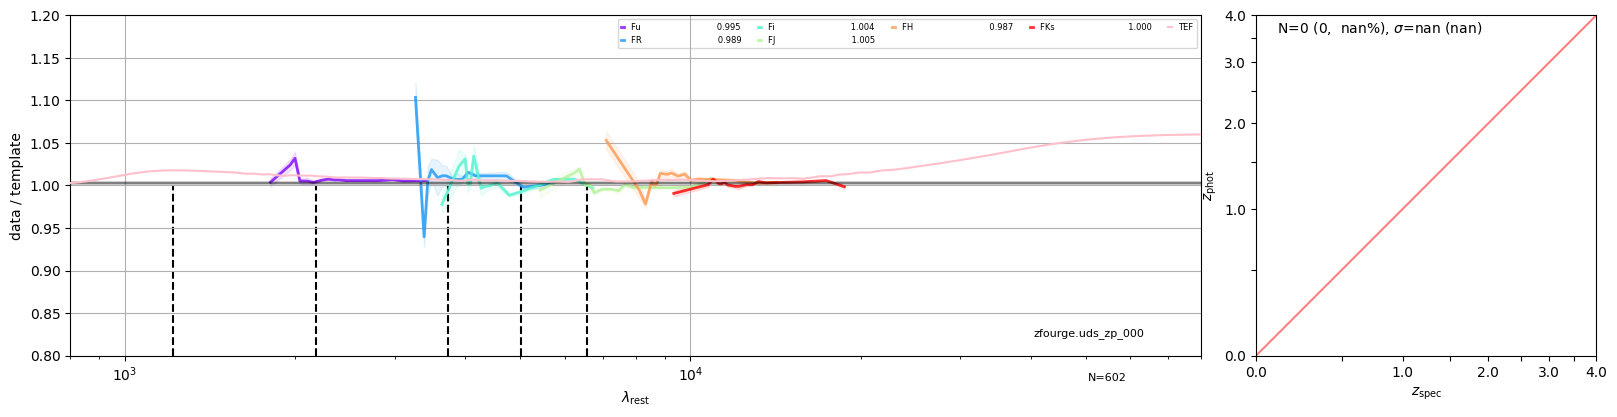

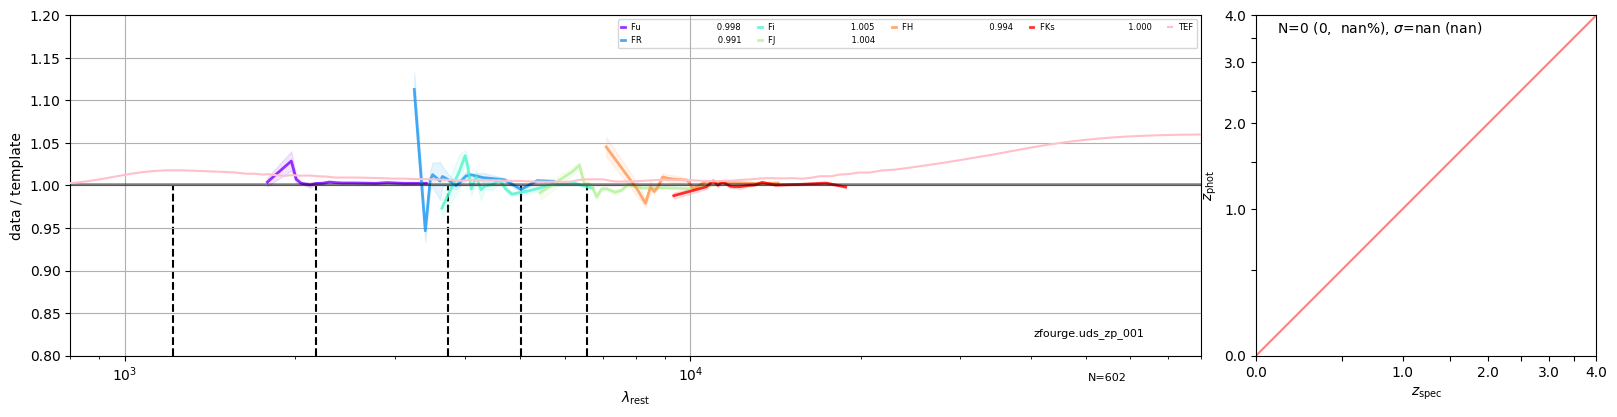

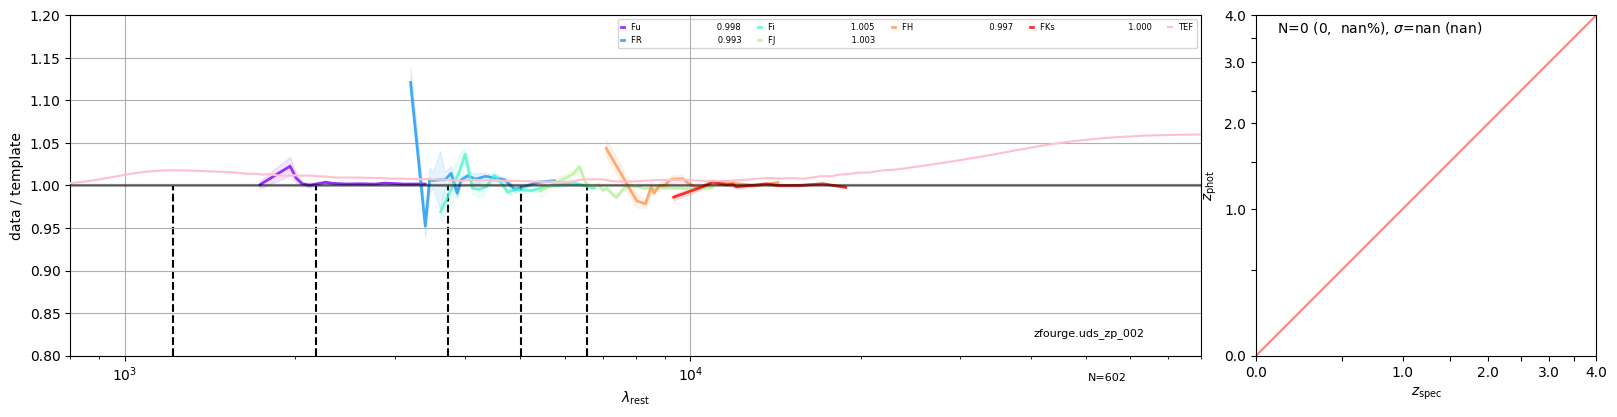

In [19]:
NITER = 3
NBIN = np.minimum(self.NOBJ//100, 180)

self.param.params['VERBOSITY'] = 1.
for iter in range(NITER):
    print('Iteration: ', iter)
    
    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False, 
                              update_zeropoints=True, iter=iter, n_proc=8, 
                              save_templates=False, error_residuals=False, 
                              NBIN=NBIN, get_spatial_offset=False)

In [20]:
# Turn off error corrections derived above
self.set_sys_err(positive=True)

# Full catalog
sample = np.isfinite(self.ZSPEC)

# fit_parallel renamed to fit_catalog 14 May 2021
self.fit_catalog(self.idx[sample], n_proc=8)

Set sys_err = 0.03 (positive=True)


100%|██████████████████████████████████████████| 511/511 [00:03<00:00, 153.97it/s]


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=631)
Fit 3.6 s (n_proc=8, NOBJ=636)


511

### Example of a redshift probability density from EAZY (PDF on y-axis, redshift grid on x-axis)

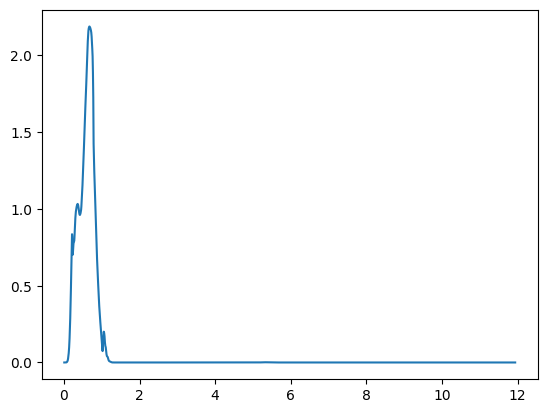

In [31]:


ind = 30

# self.full_logprior[ind,:]
plt.plot(self.zgrid,np.exp(self.lnp[ind,:]))

# best_z_val=common_z_grid[np.where(np.exp(self.lnp[ind,:])==max(np.exp(self.lnp[ind,:])))[0][0]]

In [32]:
# using EAZY z-grid as the common z_grid


common_z_grid = self.zgrid

### Now we find degenerate (double-peaked) galaxies in EAZY


In [23]:
len(Dub_data['ID'])

1219

In [24]:
deg_optical_index = []
for i in range(len(OPTICAL_indices)):
    peaks, _ = find_peaks(np.exp(self.lnp[i,:]), height=0.5)
    
    if len(peaks) >= 2:
        deg_optical_index.append(i)
        
        
   

### Example of a redshift probability density for a degenerate galaxy from EAZY

In [ ]:
# for i in range(len(deg_optical_index)):
    
#     plt.figure()
#     plt.plot(common_z_grid, np.exp(self.lnp[deg_optical_index[i],:]))
#     plt.title(f"index {deg_optical_index[i]}")
    
#     plt.xlim(0,7)
#     plt.legend()
#     plt.show()
    
    

In [33]:
#list of bad/degenerate galaxies that we want to fix

degen_galaxies = np.array([13,16,18,19,20,21,22,27,35,39,42,43,46,52,54,59,61,66,67,81,89,92,107,114,133])

## ###############################
# FIR/Submm PHOTOMETRY
## ###############################

In [34]:
#Defining the constants
c = scipy.constants.c
Beta=1.5
nu_scale=1e9
A_scale=1e-11
alpha_scale = 1e5
f = (scipy.constants.h)/(scipy.constants.k)*nu_scale
upper_bound_b = c/(8*1e-6)/nu_scale
lower_bound_c = c/(1000*1e-6)/nu_scale
amplitude_spread=0.5

wavelen_obs = np.array([250,350,500])*(10**-6)

freq_obs = (c/wavelen_obs)/nu_scale



### Assuming a modified blackbody model, we use MCMC to find the FIR photometric redshift for a galaxy

In [35]:
#get redshift and temperature for any galaxies

def get_z_and_T_for_one_galaxy(index_number):
    
    try:
    
        F250_Dublended = Dub_data['F250'][index_number]
        F350_Dublended = Dub_data['F350'][index_number]
        F500_Dublended = Dub_data['F500'][index_number]

        FIR_flux = np.array(np.abs([F250_Dublended,F350_Dublended,F500_Dublended]))

        FIR_flux_error = 0.1* FIR_flux


#         lt_params = [889.0588851152065, 2.5040970376568774]
        lt_params = [380, 2.6940970376568774]
    #     lt_params = [23133.618537869013, 1.55067652]
        index_number = index_number
        def compute_lum_dist(z_input):
            """
            Return the luminosity distance in SI units given redshift
            """
            return Distance(z=z_input, cosmology=Planck15).si.value

        def lt(e,lt_params):
            #return (10**(np.polyval(best_fit_poly, e))) * 3.828e26 

            alpha=lt_params[0]
            gamma=lt_params[1]

            return (alpha*1e5) * e**gamma * 3.828e26 

        def modified_blackbody_distribution(nu, T, A):

            B_nu = (nu**3) / (np.exp(f*nu / T) - 1)

            S_nu = (A*A_scale)  * (nu**Beta) * B_nu  

            return S_nu

        def modified_blackbody_distribution_with_lt(nu, lt_params, T_em, z):

            func_to_integrate = lambda nu1: modified_blackbody_distribution(nu1, T = T_em, A=1)

            S=(1+z)**(-Beta-4)*integrate.quad(func_to_integrate, lower_bound_c, upper_bound_b)[0]*nu_scale*1e-3*1e-26

            A=lt(T_em,lt_params)/(4*np.pi*compute_lum_dist(z)**2*S) 

            return modified_blackbody_distribution(nu, T_em/(1+z), A)

        def residual(p):
            v = p.valuesdict()

            return (modified_blackbody_distribution_with_lt(freq_obs, lt_params, v['T0'], v['z0']) - FIR_flux) / FIR_flux_error
        
        
        
        def chi_sq():
            
            chi_res = ((modified_blackbody_distribution_with_lt(freq_obs,lt_params,mi.params['T0'].value,mi.params['z0'].value) - FIR_flux) / FIR_flux_error)**2
            
            N = 3
            
            P = 2
            
            chi2 = np.sum(chi_res) / (N - P) 
            
            return chi2
        
        
        #Start MCMC

        MCMC_steps = 3000
        # Set initial fit parameters
        p0 = (20, 1)


        p = lmfit.Parameters()
        p['T0'] = lmfit.Parameter(name='T0', value=p0[0], min=5, max=60)
        p['z0'] = lmfit.Parameter(name='z0', value=p0[1], min=np.min(common_z_grid), max=np.max(common_z_grid))

        # Obtain initial fit using minimizers, use residual
        #not change residual here
        mi = lmfit.minimize(residual, params=p, method='ampgo')



        try:

            res = lmfit.minimize(residual, method='emcee', burn=300, steps=MCMC_steps, thin=10,
                                params=mi.params, is_weighted=True, progress= False)
        except:

            res = -np.inf


        # Convert MCMC outputs to gaussian kde

        # Get MCMC outputs
        Ts = np.array(res.flatchain['T0'])
        zs = np.array(res.flatchain['z0'])

        # Define normalized pdf over fit params
        values = np.vstack([Ts, zs])
        kde_kernel = gaussian_kde(values)

        ######Plot MCMC result
        K = 511
        L = 511
        T_grid = np.linspace(5, 60, K)
        z_grid = common_z_grid
    #     np.linspace(0.01, 5, L)
        p_T_z=np.zeros((K,L))
        for i in range(K):
            for j in range(L):
                p_T_z[i,j]=kde_kernel.pdf(np.array([T_grid[i], z_grid[j]]))[0]
    #     plt.figure()
    #     plt.imshow(p_T_z,origin='lower')

        p_T=np.array([simps(p_T_z[i,:], z_grid) for i in range(L)])
        p_z=np.array([simps(p_T_z[:,i], T_grid) for i in range(K)])

        best_z_val=z_grid[np.where(np.array(p_z)==max(p_z))[0][0]]
        best_T_val=T_grid[np.where(np.array(p_T)==max(p_T))[0][0]]





        #Define confidence interval
        p=0.68

        #Smooth histogram with Gaussian kernel
        p_z_smooth=gaussian_filter1d(p_z,1.5)


        #Caculate probabilities per bin
        p_z_bin=p_z_smooth/np.sum(p_z_smooth)


        #Sort probabilities
        p_z_bin_sorted,x_z_sorted=zip(*sorted(zip(p_z_bin, z_grid),reverse=True))



        #Add probabilities until confidence interval is reached
        idx=0
        PZ=p_z_bin_sorted[idx]


        while PZ < p:
            idx+=1

            PZ+=p_z_bin_sorted[idx]

        #Find min and max x value in probabilities subset
        x_z_min=np.min(x_z_sorted[:idx+1])
        x_z_max=np.max(x_z_sorted[:idx+1])

        #Find best value (either max likelihood or mean)
        # best_val=z_grid[np.where(np.array(p_z_smooth)==max(p_z_smooth))[0][0]]


        #Find uncertainty ranges
        sigma_z_minus=best_z_val-x_z_min
        sigma_z_plus=x_z_max-best_z_val



        plt.figure()

        
        CHI_SQUARED = np.sum(((modified_blackbody_distribution_with_lt(freq_obs,lt_params,mi.params['T0'].value,mi.params['z0'].value)-FIR_flux)/(0.2*FIR_flux))**2)
        

        return np.array([best_z_val,sigma_z_plus,sigma_z_minus,best_T_val,p_z_smooth/np.sum(p_z_smooth), CHI_SQUARED])
    
    except:
        
        return np.array([np.nan,np.nan,np.nan,np.nan, np.nan, np.nan])





## ###############################
# Combining FIR/Submm Photometry with EAZY's OPTICAL Photometry
## ###############################

In [36]:
# a single function that caluclates p(z) optical and FIR (normalzit it) and create joint PDF

import numpy as np
from scipy.interpolate import interp1d

def get_broadband_photometry(galaxy_index):

    
    FIR_INDEX = np.where(Dub_data['ID'][FIR_indices] == common_galaxies_ID[galaxy_index])[0][0]

    OP_INDEX = np.where(cosmos2015_data['Seq'][OPTICAL_indices] == common_galaxies_ID [galaxy_index])[0][0]
    
    
    
    z_photo_dub = Dub_data['zphot'][FIR_indices[FIR_INDEX]]
    z_spec_dub = Dub_data['zspec'][FIR_indices[FIR_INDEX]]
    
    # Generate example data for two PDFs
    # p1_z = np.exp(self.lnp[ind,:])
    
    
    get_pdz_and_chi2 = get_z_and_T_for_one_galaxy(FIR_indices[FIR_INDEX])
    
    p_FIR_chi2 = get_pdz_and_chi2[5]
    
    if (p_FIR_chi2 < 2):
        
        p_FIR = get_pdz_and_chi2[4]
        
    else:
        
        p_FIR = np.ones(len(get_pdz_and_chi2[4]))
    
    
    

    p_FIR /= np.sum(p_FIR)
    
    
    
    p_optical = np.exp(self.lnp[OP_INDEX,:])
    p_optical /= np.sum(p_optical)
    
    
    z_EAZY = common_z_grid[np.where(np.array(p_optical)==max(p_optical))[0][0]]


    # Normalize the combined PDF
    
    try:
        combined_pdf = (p_FIR * p_optical)/(np.sum(p_FIR * p_optical))
        
        z_photo = common_z_grid[np.where(np.array(combined_pdf)==max(combined_pdf))[0][0]]
        
    except:
        
        
        combined_pdf = p_optical
        
        z_photo = z_EAZY




    plt.plot(common_z_grid, combined_pdf, label='Combined')
    plt.plot(common_z_grid, p_optical, label='Optical')
    plt.plot(common_z_grid, p_FIR, label='Submm')

    plt.axvline(x=z_spec_dub, color='red', linestyle='--', label = 'Spec-z' )



    # z_cosmos_optical[ind]

    # plt.plot(common_grid, combined_pdf, label='Combined PDF')


    # plt.axvline(x=z_galaxy683_cosmos, color='red', linestyle='--', label = 'simulated z' )
    
    plt.xlim(0,7)
    
    plt.xlabel('z', fontsize = 14)
    plt.ylabel('Probability density', fontsize = 14)

    plt.legend()
#     plt.grid(True)
    plt.show()
    
    
    return np.array([z_photo,z_spec_dub,z_EAZY,z_photo_dub])

    
    

## Examples of fixing a degeneracy using FIR/Submm bands

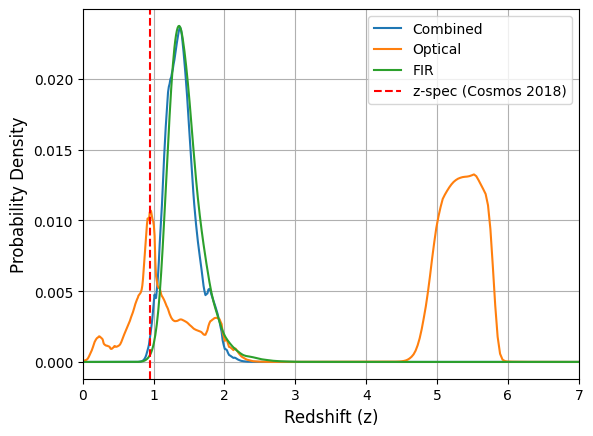

In [208]:
g126 = get_broadband_photometry(126)


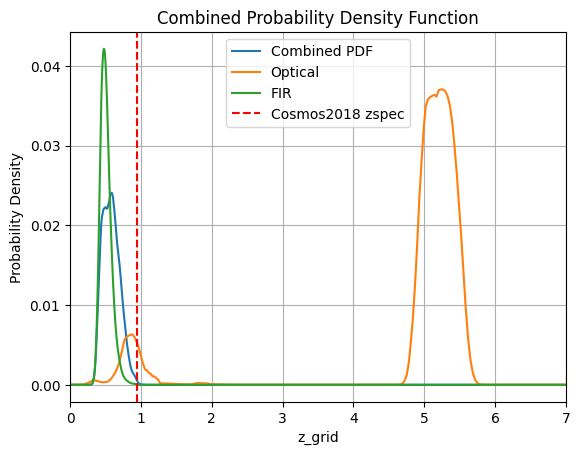

Time taken: 114.161780 seconds


In [123]:
import time

# Record start time
start_time = time.time()

get_broadband_photometry(138)

# Your code to be measured

# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.6f} seconds")


### Now we do this for bunch of galaxies, and see for how many galaxies it gets better

In [167]:
z_photometry_selected = []
z_spec_selected = []
z_EAZY_selected = []
z_photo_dub_selected = []

for i in range(len(Working_galaxy_index)):
    
    index = Working_galaxy_index[i]
    

    
    print('_____________ Galaxy ID : ', index )   
    
    
    try:
        get_z = get_broadband_photometry(index)
        
        
    except:
        get_z = np.array([np.nan,np.nan,np.nan,np.nan])
        
        
    z_photometry_selected.append(get_z[0])
    z_spec_selected.append(get_z[1])
    z_EAZY_selected.append(get_z[2])
    z_photo_dub_selected.append(get_z[3])



636

### Let's do this for all the galaxies in the catalog

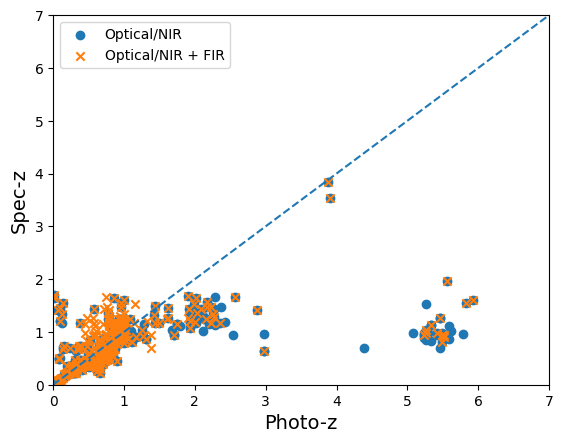

In [552]:

# plt.title('z_photo vs z_spec', fonts)


# plt.title(' Photo-z  vs Spec-z')
plt.scatter(z_EAZY_TEST,z_spec_TEST, label = 'Optical/NIR')

plt.scatter(z_photometry_TEST,z_spec_TEST, label = 'Optical/NIR + FIR', marker='x')





# plt.scatter(z_photo_dub_corrected,z_spec_corrected, label = 'Dub Photo')

plt.plot([0,8],[0,8], linestyle = 'dashed')
plt.xlabel('Photo-z', fontsize = 14)
plt.ylabel('Spec-z', fontsize = 14)

plt.xlim(0,7)
plt.ylim(0,7)

plt.legend()